# Story Story

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar # for listing days of the week
from pandas.api.types import CategoricalDtype #for setting days in the right order
import matplotlib.ticker as ticker # for drawing day/hour ticks
import numpy.polynomial.polynomial as poly # for calculating trends to plot trend lines

In [2]:
#Read in the data
df = pd.read_csv('stories_data.csv')
df.drop([0], axis = 0, inplace = True) #Drop column descriptors
#Index the df with datetimes
df.set_index(pd.to_datetime(df['timestamp']), inplace = True)
#Reset time zone to US Eastern time
df.index = df.index.tz_convert('US/Eastern')
#Drop unnecessary columns
df.drop(['timestamp', 'story_id'], axis = 1, inplace = True)
#Change remaining columns to int type
cols = ['exits', 'impressions', 'reach', 'replies', 'taps_forward', 'taps_back']
df[cols] = df[cols].astype(int)

In [33]:
df.head()

,exits,impressions,reach,replies,taps_forward,taps_back
timestamp,,,,,,
2019-10-27 12:42:13-04:00,5,157,137,0,97,4
2019-10-27 12:43:55-04:00,7,127,115,0,88,5
2019-10-27 12:45:02-04:00,3,114,107,0,79,4
2019-10-27 12:46:08-04:00,2,113,103,0,92,2
2019-10-27 12:48:40-04:00,2,109,101,0,77,5


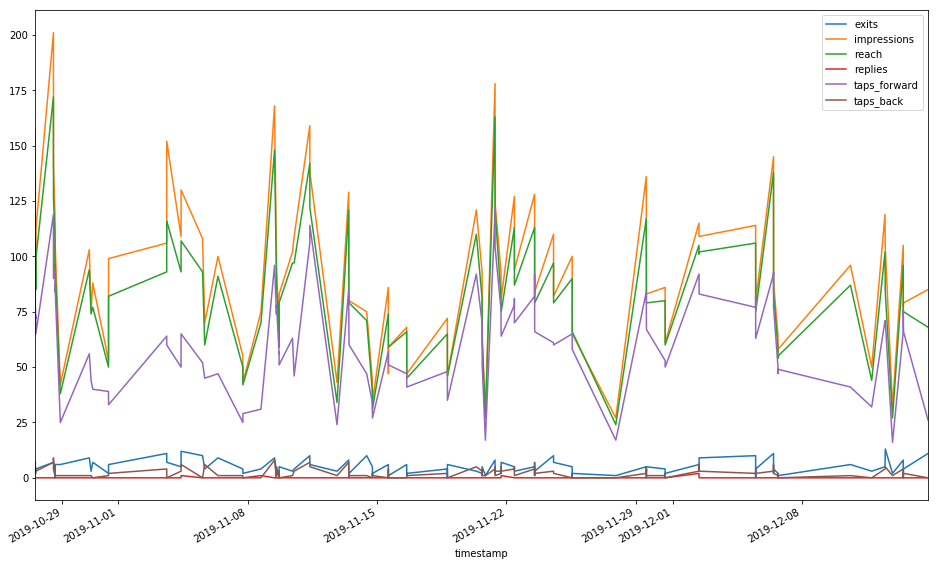

In [3]:
df.plot(figsize = (16,10))

The erratic labeling on the x axis suggests that there are missing datetimes for which there is no data. Filling these in with zeros would smooth out the x axis and reveal at what times of day user activity concentrates.

The client wants to know which time of day is best for posting, not which timestamp in the range of dates was best. We can group the data by day and hour to see at what hours of the day user activity concentrates. We'll also engineer a 'count' column with np.ones() to calculate how many stories fall within each hour in the groupby() operation.

### Get stories by hour and weekday

In [4]:
print('Earliest datetime:', df.index.min())
print('Latest datetime:', df.index.max())

Earliest datetime: 2019-10-27 12:42:13-04:00
Latest datetime: 2019-12-14 20:02:34-05:00


In [6]:
#Reset timestamps to be hour-long periods and fill in the periods with no data:
start = pd.Timestamp('2019-10-27 16:00:00+0000', tz='US/Eastern') #noon eastern
end = pd.Timestamp('2019-12-15 04:00:00+0000', tz='US/Eastern') #11pm eastern
#Create a timeframe to use for reindexing
timeframe = pd.period_range(start = start, end = end, freq = 'H')

#Set the df index to periods 
df.set_index(df.index.to_period(freq = 'H'), inplace = True)
#Create a count column for use in group_by
df['count'] = np.ones(df.shape[0])

#Group the df to eliminate duplicate indices, then reindex for the timeframe
#Creates a sparse matrix
hourly = df.groupby(df.index).sum().reindex(timeframe)

#Reset the index from periods to datetimes so that weekdays can be extracted
hourly.set_index(hourly.index.to_timestamp(), inplace = True)

#Set order of day names by calendar not alphabet
day_names = calendar.day_name[:7]
day_cats = CategoricalDtype(categories = day_names, ordered = True)
#Create multindex with weekdays (correctly ordered) and hours 
hourly_mi = hourly.groupby([hourly.index.day_name().astype(day_cats), hourly.index.hour]).sum()

C:\Users\Stee\Anaconda3good\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


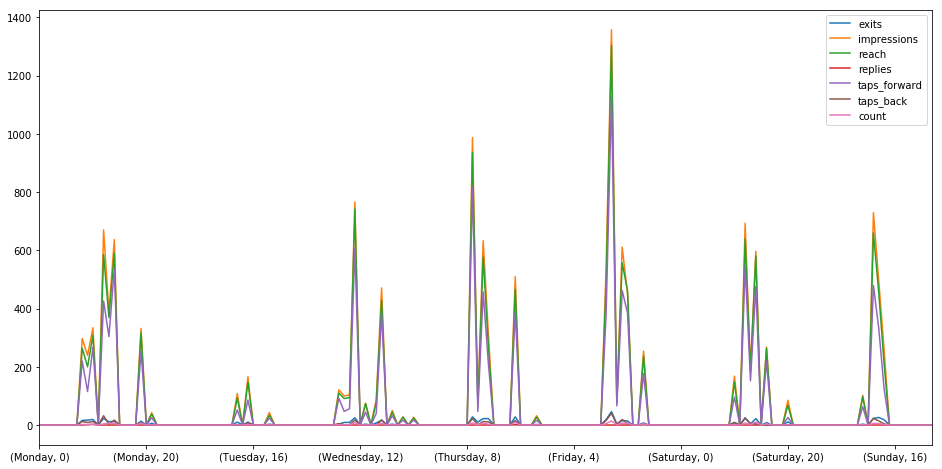

In [7]:
hourly_mi.plot(figsize = (16,8))

Now we can see the times of day when there is no activity. Some days have a lot more activity than others but it is unclear at this point how well the average story does at a given time of day. To calculate averages we'll use the count column we created above in the groupby() operation.


### Get averages by hour and weekday

Text(0.5, 1.0, 'Average story hits by hour')

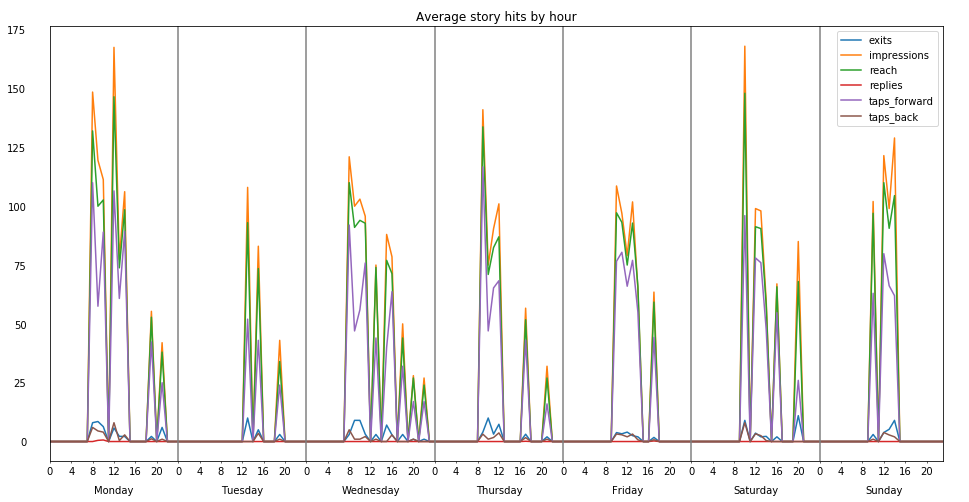

In [9]:
#Divide each column by its number of stories to get the mean
hourly_means = pd.DataFrame({col: hourly_mi[col] / hourly_mi['count'] for col in cols}).fillna(0)

#Plot hourly means 
ax = hourly_means.plot(figsize = (16, 8), x_compat = True)

#Create minor and major ticks to records hours and days
#Hours:
hour_mult = 4 #multiple locator 
#Get ticks only for the hours set by the multiple locator
hour_ticks = [''] + [tup[1] for i, tup in enumerate(hourly_means.index) if i % hour_mult == 0]
ax.xaxis.set_minor_locator(ticker.MultipleLocator(hour_mult))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(hour_ticks))
#Days:
#Position the day labels at noon on each day
ax.xaxis.set_major_locator(ticker.IndexLocator(base = 24, offset = 12))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(day_names))
ax.tick_params(which='major', length= 20, color = 'white') #Hide tick mark
#Draw dividing lines between days
[ax.axvline(i * 24, color = 'gray') for i in range(1, len(day_names))]
plt.title('Average story hits by hour')

This plot makes the values taken at each hour commensurable. Now we know that Mondays at noon *on average* get more activity than, say, Tuesdays at noon. The striking trend I notice on each day is a downward slope from earlier in the day to later in the day. The client might like to see the trend plotted.

The other trend I notice is a tight correlation between 'impressions' and 'reach'/'taps forward.' We can probably get all the insights we need just from the impressions column.

### Plot impressions with trend lines for each day

In [98]:
#Get impressions column for each day
unstacked = hourly_means['impressions'].unstack().T

#Get indices for non-zero xs ('exes') and ys ('whys') at each day
xs = {day: np.array(unstacked[day][unstacked[day] != 0].index) for day in day_names}
ys = {day: unstacked[day][unstacked[day] != 0].values for day in day_names}

#Calculate trends for each set of x and y
ffits = {day: poly.polyval(xes[day], poly.polyfit(xs[day], ys[day], 1)) \
         for day in day_names}

Text(0.5, 1.0, 'Average impressions by hour with trend lines')

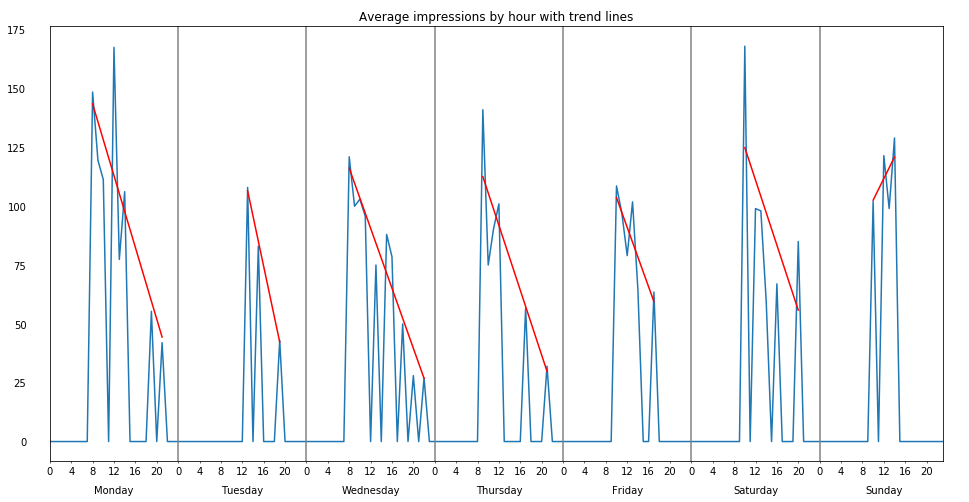

In [102]:
#Plot impressions with trend lines
ax = hourly_means['impressions'].plot(figsize = (16, 8), x_compat = True)
#Plot trend lines     
[plt.plot(xs[day] + (24 * i),
          ffits[day],
          color = 'red')\
     for i, day in enumerate(day_names)]
#Create minor and major ticks to records hours and days
#Hours:
ax.xaxis.set_minor_locator(ticker.MultipleLocator(hour_mult))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(hour_ticks))
#Days:
#Center the label at noon each day
ax.xaxis.set_major_locator(ticker.IndexLocator(base = 24, offset = 12)) 
ax.xaxis.set_major_formatter(ticker.FixedFormatter(day_names))
ax.tick_params(which='major', length= 20, color = 'white') # Hide tick mark
#Draw dividing lines between days
[ax.axvline(i * 24, color = 'gray') for i in range(1, len(day_names))]

plt.title('Average impressions by hour with trend lines')

There's a striking downward trend on six days of the week. We can tell the client that their stories posted in the morning will get the most impressions, and that they'll get fewer and fewer hour by hour for stories posted as the day goes on. The intuition here is that a given user will have more opportunities throughout the day to look at a story posted in the morning. Even though a particular user may not check Instagram until the evening, this plays out as a linear relationship between time of day and impressions in a large enough population of users.

In [7]:
#TREND LINES FOR WHEN THE TIMEZONE WAS WRONG:

#Here is an interesting solution I came up with to get the same trend lines 
#as above before I realized I was using the wrong timezone. I thought I needed
#trend lines from each day at 4am to the next day at 3am.

#Get slices of df from 4am to 3am each day
#impressions_4to4 = {day: hourly_means['impressions'].loc[(slice((day, 4), (day_names[i + 1], 3)))]   for i, day in enumerate(day_names[:-1])}
#manually add in values for sunday that end at hour 24
#impressions_4to4['Sunday'] = hourly_means['impressions'].loc[(slice(('Sunday', 4), ('Sunday', 24)))]

#Get indices for non-zero values at each day
#xs = {day: np.array([tup[1] for tup in impressions_4to4[day][impressions_4to4[day] != 0].index]) for day in day_names}
#ys = {day: impressions_4to4[day][impressions_4to4[day] != 0].values for day in day_names}

#Change the values to follow the logic of x ticks for hours accumulating continuously
#not starting over each day
#for i, day in enumerate(day_names):
#    xs[day] = [val + (24 * i) if val > 4 else val + (24 * (i + 1))  for val in xs[day]]
    
#Get trends for each set of x and y
#ffits = {day: poly.polyval(xs[day], poly.polyfit(xs[day], ys[day], 1)) \
#         for day in day_names}

### By hour only, not day

Just to drive the point home that stories posted earlier will get more impressions, we can collapse the days of the week into one and show the data hour by hour.

Text(0.5, 1.0, 'Average hits on stories posted hour by hour')

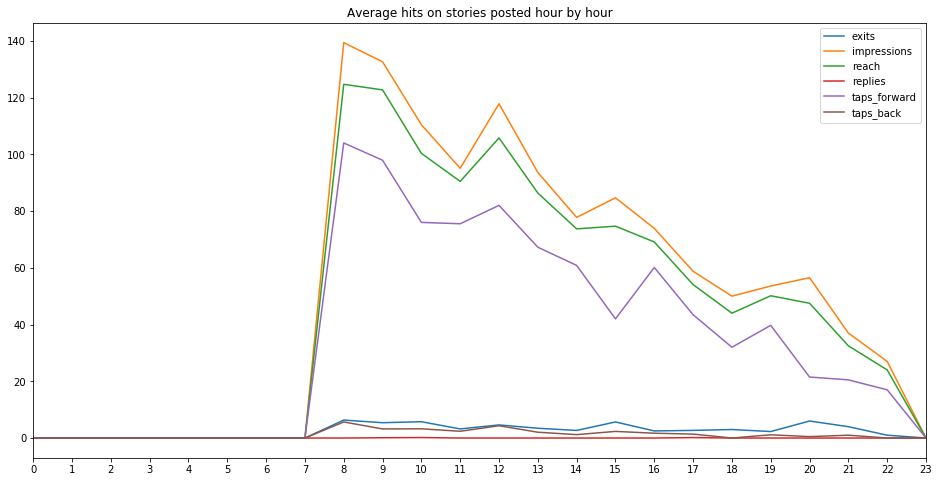

In [104]:
#Collapse the days of the week into one ideal average day
byhour = hourly.groupby(hourly.index.hour).sum()

#Divide each column by its number of stories to get the mean
by_hour_means = pd.DataFrame({col: byhour[col] / byhour['count'] for col in cols}).fillna(0)

#Plot hits by hour
by_hour_means.plot(figsize = (16,8), x_compat = True)
plt.xticks(np.array(byhour.index))
plt.title('Average hits on stories posted hour by hour')